In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN_II.ipynb"
#!python setup.py develop 
#!pip install wandb
#!pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer
#!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [2]:
import json, glob, random, re, collections, time, cv2, torch

import numpy as np
import wandb as wb
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from scipy.io import loadmat as lm
from enum import Enum
from torch import nn
from torch.utils import data as torch_data
from sklearn.model_selection import train_test_split
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from monai.networks import nets
from monai.data import (
    DataLoader,
    ImageDataset,
    ArrayDataset,
)
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from efficientnet_pytorch_3d import EfficientNet3D
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


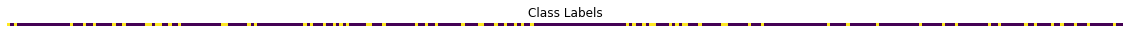

In [3]:
# Set data directory
rootDir = '/red/camctrp/working/Alejandro/StimBrain'
mri_types = ['J'] # 'EPI'
subs = np.array([9009, 9015, 9022, 9040, 9044, 9045, 9051, 9021, 9023, 9031, 9032, 9047, 9048, 9054]) # Subjects
beh = np.array([32, 26, 19, 20, 20, 17, 15, 2, 4, 6, 10, 16, 18, 7]) # Targeted Behavior Change
T1_SIZE = (256,256,256)
T1_PATCH = (64,64,64)
BATCH_SIZE = 17
N_EPOCHS = 20
SEED = 42
LEARNING_RATE = 1e-2
reg = 1;
LR_DECAY = 9e-1

# Define Group Labels as above/below Median
lab = np.zeros([len(beh),1]);
lab[beh >= np.median(beh)] = 1; # Responders
lab[beh < np.median(beh)] = -1; # Non Responders

num_of_cores = int(os.environ['SLURM_CPUS_PER_TASK'])

# Two binary labels for Healthy vs pre-MCI
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).float()

# MPRAGE Data
# T1w_images = np.array([os.path.join(anatDir,''.join(['sub-',str(sdata[s,0])]),'ses-01','anat',''.join([regs[reg],'sub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
T1w_images = np.array([os.path.join(rootDir,''.join(['FS6.0_sub-',str(sdata[s,0]),'_ses01']),'ROAST_output','T1_Jbrain.nii') for s in range(sdata.shape[0])]);
# T1w_images = T1w_images[exclude]; # Remove 20ch Head Coils

class Diagnosis(Enum):
    normal = 0
    preMCI = 1

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

T1 Shape: (176, 256, 256) 
CONN Shape: (51, 51)


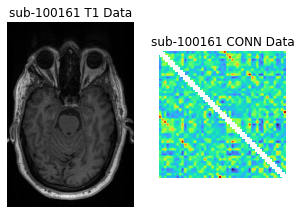

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)    

# Plot OG Images
fig, axes = plt.subplots(*[1,2], figsize=(5, 5), facecolor="white")

# T1w
axes[0].set_title(''.join(['sub-',str(sdata[0,0]),' T1 Data']));
nii = nib.load(T1w_images[0]); # Load Each Electrode
axes[0].imshow(nii.get_fdata()[:, :, 100].T, cmap="gray", origin="lower"); axes[0].axis('off'); 
# EPI
axes[1].set_title(''.join(['sub-',str(sdata[0,0]),' CONN Data']));
mat = pd.read_csv(EPI_images[0],delimiter=',',header=None); # Load Each Electrode
axes[1].imshow(mat, cmap="turbo"); axes[1].axis('off');
print('T1 Shape:',nii.shape,'\nCONN Shape:',mat.shape)

In [5]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        mlp_dim = 2048
        for _ in range(depth):
            #print (dim, mlp_dim)
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class Model(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size[0] % patch_size[0] == 0, 'image dimensions must be divisible by the patch size'
        num_patches = int(np.prod(np.divide(image_size,patch_size))); # 3D
        patch_dim = channels * np.prod(patch_size)

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        #print (mlp_dim)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        #print (dim)
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
            nn.Dropout(dropout)
        )

    def forward(self, img, mask = None):
        p = self.patch_size # PAT_SIZE 1D
#         print (img.shape)
        x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1 = p[0], p2 = p[1], p3 = p[2]) # SPLIT IMAGE INTO 3D PATCHES (b, # patchs, # patch features)
#         print (x.shape)
        x = self.patch_to_embedding(x) # Patch Embedding
#         print (x.shape)
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1) 
#         print (cls_tokens.shape)
        x = torch.cat((cls_tokens, x), dim=1)
#         print (x.shape)
#         print (self.pos_embedding.shape)
        x += self.pos_embedding # Patch Embbeding + Position Embedding
        x = self.dropout(x)

        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0]) # class token
        return self.mlp_head(x)

In [6]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer,
        criterion
    ):
        self.model = model
        self.device = device
        self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = 0.0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
        wb.init(project="ACT-ViT",
           config={
               "batch_size": BATCH_SIZE,
               "Num_Epochs": N_EPOCHS,
               "T1_size": T1_SIZE,
               "T1_Patch": T1_PATCH,
               "EPI_size": EPI_SIZE,
               "EPI_Patch": EPI_PAT,
               "Registration": reg,
               "learning_rate": LEARNING_RATE,
               "lr_decay": LR_DECAY,
               "RNG_Seed": SEED,
               "dataset": "ACT",
           })
        wb.watch(self.model, log='all')
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            # Train
            train_loss, train_time = self.train_epoch(train_loader)
            wb.log({'train_loss': train_loss, 'train_time': train_time})
            self.train_losses.append(train_loss)
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            # Validation
            if epochs > 100: 
                val_int = epochs/10 
            elif epochs <= 100:
                val_int = 1;
            if n_epoch % val_int == 0:
                valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                wb.log({'valid_loss': valid_loss, 'valid_auc': valid_auc, 'valid_time': valid_time})
                self.val_losses.append(valid_loss)
                self.val_auc.append(valid_auc)

                self.info_message(
                    "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                    n_epoch, valid_loss, valid_auc, valid_time
                )

                if self.best_valid_score < valid_auc: 
                    self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                    self.info_message(
                         "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                        self.best_valid_score, valid_auc, self.lastmodel
                    )
                    self.best_valid_score = valid_auc
                    self.n_patience = 0
                else:
                    self.n_patience += 1
            
                if self.n_patience >= patience:
                    self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                    break
        wb.run.log_code("."); wb.finish() # Stop W&B log
        
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch[0].clone().float().to(self.device);
            targets = batch[1].to(self.device);
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets.float())            
            self.scaler.scale(loss).backward()
            
#             loss.backward()

            sum_loss += loss.detach().item()
            self.scaler.step(self.optimizer)
            self.scaler.update()
#             self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch[1].to(self.device)

                output = self.model(batch[0].clone().detach().float().to(self.device)).squeeze(1)
                loss = self.criterion(output, targets.float())
                sum_loss += loss.detach().item()
                output = torch.sigmoid(output)
                
                y_all.extend(batch[1].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [7]:
nontest_list, test_list = train_test_split(subIdx, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
nontest_label, test_label = train_test_split(lab.T, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
train_list, valid_list = train_test_split(nontest_list, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED);
print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
del nontest_list, nontest_label; # Save RAM

train case split:  57 : 232
valid case split:  6 : 27
test case split:  3 : 14 



In [ ]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def build_model():
# #     model = nets.ViTAutoEnc(in_channels=1, img_size=IM_SIZE, patch_size=PAT_SIZE)
#     model = nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
#     return model  
# class build_model():
#     def __init__(self):
#         super().__init__()
#         self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         n_features = self.net._fc.in_features
#         self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
#     def forward(self, x):
#         out = self.net(x)
#         return out

def train_mri_type(df_train, df_valid, train_lab, valid_lab, mri_type):
#     print(df_train.shape, df_valid.shape)
#     display(df_train.head())
#     display(df_valid.head())

    if mri_type == 'T1':
        # Define transforms
        train_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(T1_SIZE),
        RandGaussianNoise(), 
        EnsureType(data_type='tensor')]);
        train_ds = ImageDataset(image_files=T1w_images[df_train], labels=train_lab[:,0], transform=train_transforms);
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1,
        dim = T1_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = T1_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    elif mri_type == 'EPI':
        # Define transforms
        train_transforms = Compose([AddChannel(),AddChannel(),EnsureType(data_type='tensor')]);
        train_ds = ArrayDataset(img=EPI[df_train,:,:], labels=train_lab[:,0], img_transform=train_transforms);
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1,
        dim = EPI_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = EPI_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_of_cores, pin_memory=pin_memory);

    # create a validation data loader
    if mri_type == 'T1':
        val_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(T1_SIZE),
        EnsureType(data_type='tensor')]);
        valid_ds = ImageDataset(image_files=T1w_images[df_valid], labels=valid_lab[:,0], transform=val_transforms);
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1,
        dim = T1_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = T1_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    elif mri_type == 'EPI':
        val_transforms = Compose([AddChannel(),AddChannel(),EnsureType(data_type='tensor')]);
        valid_ds = ArrayDataset(img=EPI[df_valid,:,:], labels=valid_lab[:,0], img_transform=val_transforms);
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1,
        dim = EPI_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = EPI_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=num_of_cores, pin_memory=pin_memory)

#     model = build_model()
   
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(train_list, valid_list, train_label, valid_label, m) for m in mri_types]
    print(modelfiles)

EPOCH: 1
[Epoch Train: 1] loss: 9.2209, time: 68.00 s
[Epoch Valid: 1] loss: 6.4370, auc: 0.5062, time: 9.00 s
auc improved from 0.0000 to 0.5062. Saved model to 'T1-e1-loss6.437-auc0.506.pth'
EPOCH: 2


In [ ]:
def predict(modelfile, df, lab, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    
    # create a validation data loader
    if mri_type == 'T1':
        val_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(T1_SIZE),
        EnsureType(data_type='tensor')]);
        val_ds = ImageDataset(image_files=T1w_images[df], labels=lab, transform=val_transforms)
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1,
        dim = T1_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = T1_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    elif mri_type == 'EPI':
        val_transforms = Compose([AddChannel(),AddChannel(),EnsureType(data_type='tensor')]);
        val_ds = ArrayDataset(img=EPI[df,:,:], labels=lab, img_transform=val_transforms)
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1,
        dim = EPI_SIZE[0]*4,
        depth = 2,
        heads = 16,
        mlp_dim = EPI_SIZE[0]*8,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
        )
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=num_of_cores, pin_memory=pin_memory)
   
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    for e, batch in enumerate(val_loader,1):
        print(f"{e}/{len(val_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch[0].clone().detach().float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
    return y_pred

# Infer with Ensemble Model

In [ ]:
avg_prob = np.zeros(test_label[:,0].shape)
for m, mtype in zip(modelfiles,  mri_types):
    prob = predict(m, test_list, test_label[:,0], mtype, "valid"); 
    avg_prob += prob
avg_prob /= len(modelfiles); print(avg_prob)
auc = roc_auc_score(test_label[:,0], avg_prob)
print(f"Validation ensemble AUC: {auc:.6f}")